In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

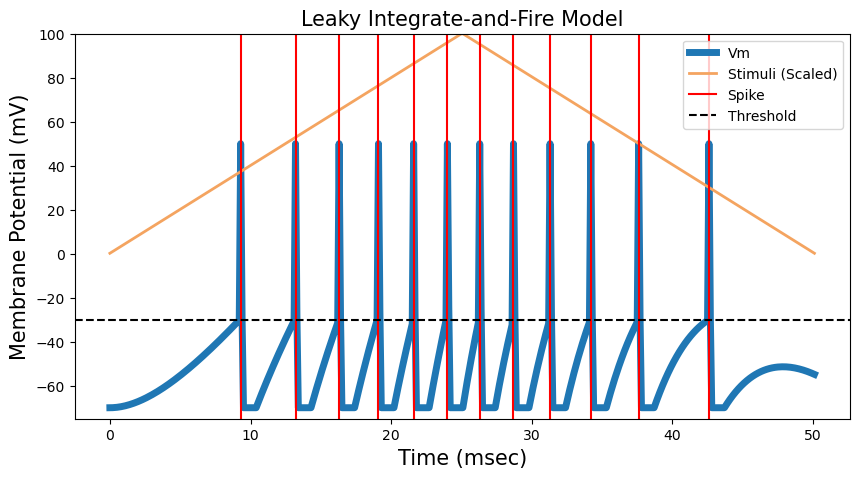

In [17]:
# MODEL PARAMETERS
T       = 50    # Simulation time          [mSec]
dt      = 0.1   # Simulation time interval [mSec]
t_init  = 0     # Stimulus init time       [V]
vRest   = -70   # Resting potential        [mV]
Rm      = 1     # Membrane Resistance      [kOhm]
Cm      = 5     # Capacitance              [uF]
tau_ref = 1     # Repreactory Period       [mSec]
vTh     = -30   # Spike threshond          [mV]
I       = 0.2   # Current stimulus         [mA]
vSpike  = 50    # Spike voltage            [mV]

# SIMULATION PARAMETERS
time    = np.arange(0, T*1e-3 + dt*1e-3, dt*1e-3)  # Time array
Vm      = np.ones(len(time))*vRest*1e-3            # Membrane voltage array
tau_m   = Rm*1e3 * Cm*1e-6                         # Time constant 
spikes  = []                                       # Spikes timings

# DEFINING THE STIMULUS
stim = I*1e-3 * signal.windows.triang(len(time)) # Triangular stimulation 

# SIMULATING
for i, t in enumerate(time[:-1]):
    if t > t_init:
        uinf = vRest*1e-3 + Rm*1e3 * stim[i]
        Vm[i+1] = uinf + (Vm[i]-uinf)*np.exp(-dt*1e-3/tau_m)
        if Vm[i] >= vTh*1e-3:
            spikes.append(t*1e3) 
            Vm[i]=vSpike*1e-3
            t_init = t + tau_ref*1e-3
            
# PLOTTING            
plt.figure(figsize=(10,5))
plt.title('Leaky Integrate-and-Fire Model', fontsize=15) 
plt.ylabel('Membrane Potential (mV)', fontsize=15) 
plt.xlabel('Time (msec)', fontsize=15)
plt.plot(time*1e3, Vm*1e3, linewidth=5, label = 'Vm')
plt.plot(time*1e3, 100/max(stim)*stim, label = 'Stimuli (Scaled)', color='sandybrown', linewidth=2)
plt.ylim([-75,100])
plt.axvline(x=spikes[0], c='red', label = 'Spike')
for s in spikes[1:]:
    plt.axvline(x=s, c='red')
plt.axhline(y=vTh, c='black', label = 'Threshold', linestyle='--')
plt.legend()

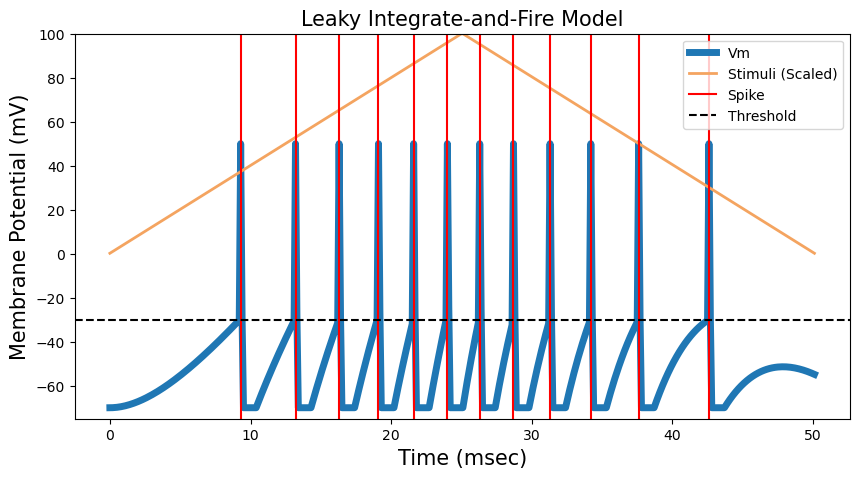

In [18]:
T       = 50    # Simulation time          [mSec]
dt      = 0.1   # Simulation time interval [mSec]
t_init  = 0     # Stimulus init time       [V]
vRest   = -70   # Resting potential        [mV]
Rm      = 1     # Membrane Resistance      [kOhm]
Cm      = 5     # Capacitance              [uF]
tau_ref = 1     # Repreactory Period       [mSec]
vTh     = -30   # Spike threshond          [mV]
I       = 0.2   # Current stimulus         [mA]
vSpike  = 50    # Spike voltage            [mV]

time    = np.arange(0, T*1e-3 + dt*1e-3, dt*1e-3)  # Time array
Vm      = np.ones(len(time))*vRest*1e-3            # Membrane voltage array
tau_m   = Rm*1e3 * Cm*1e-6                         # Time constant 
spikes  = []                                       # Spikes timings
spikes_stim = []                                  # Stimuli timings 
spikes_freq = []                                 # Spikes frequency

stim = I*1e-3 * signal.windows.triang(len(time)) # Triangular stimulation 

for i, t in enumerate(time[:-1]):
    if t > t_init:
        uinf = vRest*1e-3 + Rm*1e3 * stim[i]
        Vm[i+1] = uinf + (Vm[i]-uinf)*np.exp(-dt*1e-3/tau_m)
        if Vm[i] >= vTh*1e-3:
            spikes.append(t*1e3) 
            spikes_stim.append(stim[i])
            Vm[i]=vSpike*1e-3
            t_init = t + tau_ref*1e-3
            
plt.figure(figsize=(10,5))
plt.title('Leaky Integrate-and-Fire Model', fontsize=15) 
plt.ylabel('Membrane Potential (mV)', fontsize=15) 
plt.xlabel('Time (msec)', fontsize=15)
plt.plot(time*1e3, Vm*1e3, linewidth=5, label = 'Vm')
plt.plot(time*1e3, 100/max(stim)*stim, label = 'Stimuli (Scaled)', color='sandybrown', linewidth=2)
plt.ylim([-75,100])
plt.axvline(x=spikes[0], c='red', label = 'Spike')
for s in spikes[1:]:
    plt.axvline(x=s, c='red')
plt.axhline(y=vTh, c='black', label = 'Threshold', linestyle='--')
plt.legend()

Calculate I-F Curves

In [24]:
spikes_stim

[7.450199203187251e-05,
 0.0001055776892430279,
 0.0001302788844621514,
 0.00015258964143426295,
 0.00017250996015936255,
 0.0001916334661354582,
 0.00019003984063745022,
 0.0001709163346613546,
 0.000150199203187251,
 0.00012709163346613547,
 0.0001,
 6.01593625498008e-05]

In [20]:
# For each time in spikes, calculate the difference between the current and previous spike time and subsequently the frequency.
for i in range(1, len(spikes)):
    spike_diff = spikes[i] - spikes[i-1]
    spike_freq = 1 / (spike_diff)  # spike frequency in milliseconds.
    spikes_freq.append(spike_freq)

In [25]:
spikes_freq

[0.2564102564102565,
 0.32258064516129015,
 0.35714285714285704,
 0.4,
 0.4166666666666669,
 0.43478260869565205,
 0.4166666666666669,
 0.3846153846153844,
 0.3448275862068963,
 0.29411764705882365,
 0.2]

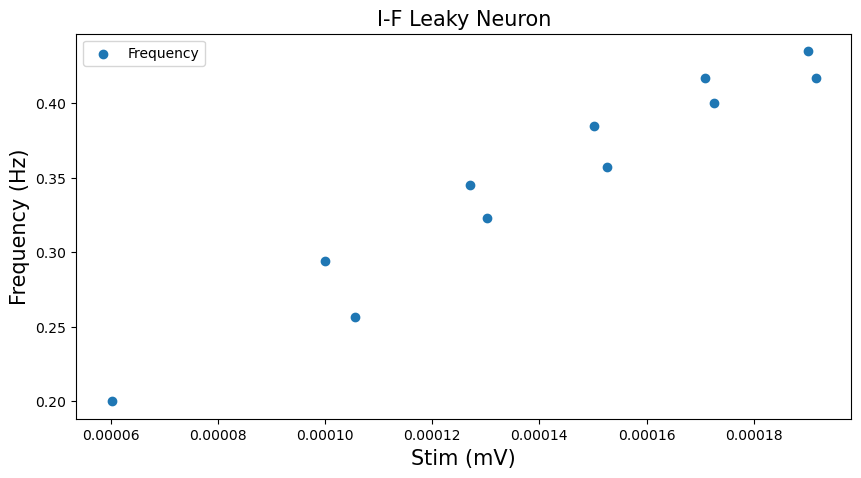

In [26]:
plt.figure(figsize=(10,5))
plt.title('I-F Leaky Neuron', fontsize=15)
plt.ylabel('Frequency (Hz)', fontsize=15)
plt.xlabel('Stim (mV)', fontsize=15)
plt.scatter(spikes_stim[1:], spikes_freq, label='Frequency')
plt.legend()
plt.show()

V-T Relationship

/tmp/ipykernel_10872/2030711394.py:39: RuntimeWarning: divide by zero encountered in log
  t_th = -tau_m * np.log(1 - (V_th - V_rest) / (Rm * I))
/tmp/ipykernel_10872/2030711394.py:39: RuntimeWarning: invalid value encountered in log
  t_th = -tau_m * np.log(1 - (V_th - V_rest) / (Rm * I))


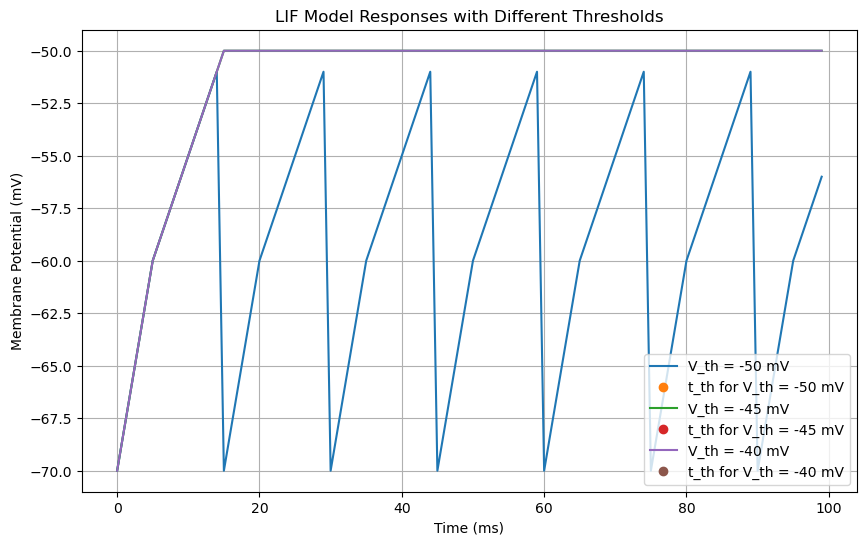